In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from utils import plot_DB, plot_DR
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

### Binary Logistic Regression

In [2]:
X, y = make_blobs(n_samples=100, centers=2, n_features=2, cluster_std=2, random_state=20)

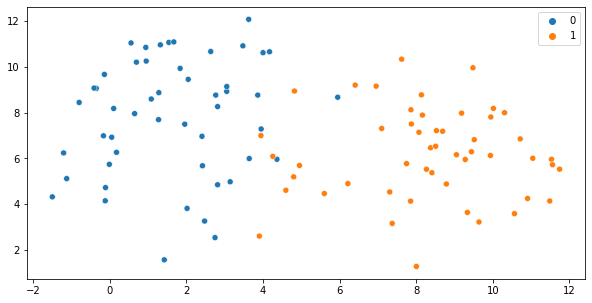

In [3]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

# Iterative Reweighted Least-Squares (IRLS)
- $W^{\tau+1} = W^{\tau} - H^{-1} \nabla E(W)$, where $H^{-1}$ is the Hessian matrix of $E(W)$
- Substituting with :
    - $\nabla E(W) = \Phi^T(Y - \mathbf{t})$
    - $H = \Phi^T R\;\Phi$, where $R = y_n (1- y_n)$
- $W^{\tau+1} = (\Phi^T R\;\Phi)^{-1}\;\Phi^TRZ = H^{-1} \Phi^{T} R Z$, where $Z = \Phi^T\;W^{\tau} - R^{-1}(Y-\mathbf{t})$ 
- #### Steps:
    - Initialize $W$ with $W^0$
    - Initialize $\mathbf{t}$ with $\frac{exp(W_0^TX)}{1 + exp(W_0^TX)} = 0.5$
    - For i in range number_of_epochs:
        - Update $R^{(i)} = y^{(i-1)} (1 - y^{(i-1)})$
        - Update the weighted adjusted response $Z^{(i-1)} = \Phi^T\;W^{(i-1)} - (R^{(i-1)})^{-1}(Y-\mathbf{t}^{(i-1)})$ 
        - Calulate the $E(W)^{(i)}$
        - $if\;(i > 1)\;\; and\;\; (E(W)^{(i)} - E(W)^{(i-1)}) < \delta$:
            - break
        - Update $W$

In [4]:
class IRLS:
    def __init__(self, num_epochs=100, scale=True):
        self.num_epochs = num_epochs
        self.scale = scale
        
    def init_w(self, size):
        self.W = np.random.normal(loc=0.0, scale=0.01, size=size)
        
    def _scale_fit(self, X, L=-1, H=1):
        P = X.shape[1]
        self.a = []
        self.b = []
        for p in range(P):
            self.a.append(((H * min(X[:, p])) - (L * max(X[:, p])))/(H - L))
            self.b.append((max(X[:, p]) - min(X[:, p]))/(H - L))
    
    def _scale_transform(self, X):
        X_scaled = (X - self.a)/self.b
        return X_scaled.reshape(X.shape[0], -1)
    
    def _scale_inverse(self, X):
        return (X * self.b) + self.a
    
    def _sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    
    def fit(self, X, Y):
       
        # Data scale
        if self.scale:
            self._scale_fit(X)
            X = self._scale_transform(X)
        
        # Initialize weights with random values
        self.init_w(X.shape[1])
        
        # for convergence check
        W_old = np.inf
        
        for i in range(self.num_epochs):
            # Initialize t
            t = self.predict(X, prob=True)
            # Calculate gradient and hessian of E(W)
            grad_E = X.T.dot((Y - t))
            # Calculate R
            R = Y * (1 - Y)
            # Calculate the Hessian matrix
            H = X.T.dot(np.diag(R)).dot(X)
            H += np.eye(H.shape[0]) * 1e-6  # add small jitter to the diagonal of H
            # Update the weights
            self.W -= np.linalg.inv(H).dot(grad_E)
            # Check for convergence
            if np.allclose(self.W, W_old):
                break
            W_old = self.W
            
    def predict(self, X, prob=False, threshold=0.5):
        if self.scale:
            X = self._scale_transform(X)
        probabilities = self._sigmoid(X.dot(self.W))
        if prob:
            return probabilities
        return (probabilities > threshold).astype(int)

In [5]:
model = IRLS(num_epochs=100)
model.fit(X, y)

In [7]:
# Calculate accuracy
acc = str(100*sum(model.predict(X)!=y)/len(y))+'%'
print('Accuracy:', acc)

Accuracy: 97.0%


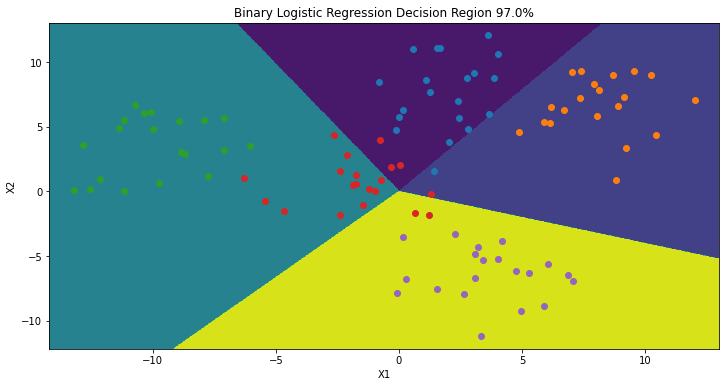

In [17]:
plot_DR(X, y, model, 'Binary Logistic Regression Decision Region {}'.format(acc), h=0.05)

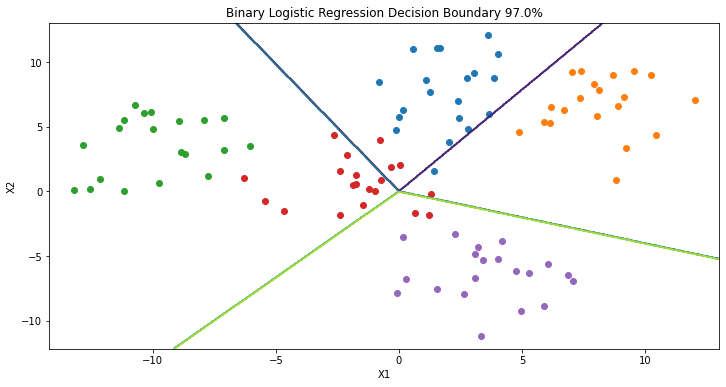

In [18]:
plot_DB(X, y, model, 'Binary Logistic Regression Decision Boundary {}'.format(acc), h=0.05)

### Multi-class Logistic Regression

In [19]:
X, y = make_blobs(n_samples=100, centers=5, n_features=2, cluster_std=2, random_state=20)

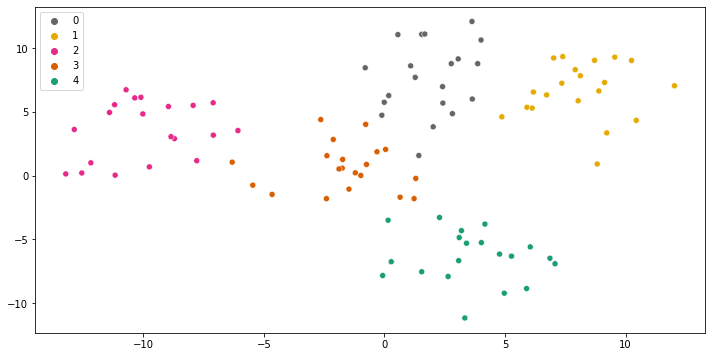

In [20]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='Dark2_r');

In [21]:
class IRLS:
    def __init__(self, num_epochs=100, scale=False):
        self.num_epochs = num_epochs
        self.scale = scale
        
    def init_w(self):
        self.W = self.W = np.random.normal(loc=0.0, scale=0.01, size=(self.P, self.K))
        
    def _scale_fit(self, X, L=-1, H=1):
        P = X.shape[1]
        self.a = []
        self.b = []
        for p in range(P):
            self.a.append(((H * min(X[:, p])) - (L * max(X[:, p])))/(H - L))
            self.b.append((max(X[:, p]) - min(X[:, p]))/(H - L))
    
    def _scale_transform(self, X):
        X_scaled = (X - self.a)/self.b
        return X_scaled.reshape(X.shape[0], -1)
    
    def _scale_inverse(self, X):
        return (X * self.b) + self.a

    def _softmax(self, a):
        # Find the maximum value along the last axis
        a_max = np.max(a, axis=-1, keepdims=True)
        # Subtract the maximum value from the elements of a and exponentiate
        exp_a = np.exp(a - a_max)
        # Normalize the exponentiated values by dividing by the sum along the last axis
        return exp_a / np.sum(exp_a, axis=-1, keepdims=True)

    def _one_of_K_coding(self, y):
        ys = len(np.unique(y))
        N = len(y)
        y_encoded = np.zeros((N, ys))
        for i in range(N):
            y_encoded[i][y[i]] = 1
        return y_encoded
    
    def fit(self, X, Y, lr=0.001):
        # Data dimenssions
        self.N, self.P, self.K = X.shape[0], X.shape[1], len(np.unique(Y))
        # Data scale
        if self.scale:
            self._scale_fit(X)
            X = self._scale_transform(X)
        # One-hot encode the targets
        Y = self._one_of_K_coding(Y)
        # Initate W
        self.init_w()
        # for convergence check
        W_old = np.inf
        
        for _ in range(self.num_epochs):
            # Calculate t
            t = self._softmax(X @ self.W)
            # Compute grad of E
            grad = X.T @ (t - Y)
            # Update W
            self.W -= lr * grad
            
            if np.allclose(self.W, W_old, atol=1e-10):
                break
         
    def predict(self, X, prob=False):
        if self.scale:
            X = self._scale_transform(X)
        probabilities = self._softmax(X.dot(self.W))
        if prob:
            return probabilities
        return np.argmax(probabilities, axis=1)

In [22]:
model = IRLS(num_epochs=100)
model.fit(X, y)

In [23]:
# Make predictions on test set
Y_pred = model.predict(X)

# Calculate accuracy
accuracy = np.mean(Y_pred == y)*100
print('Accuracy:', accuracy)

Accuracy: 79.0


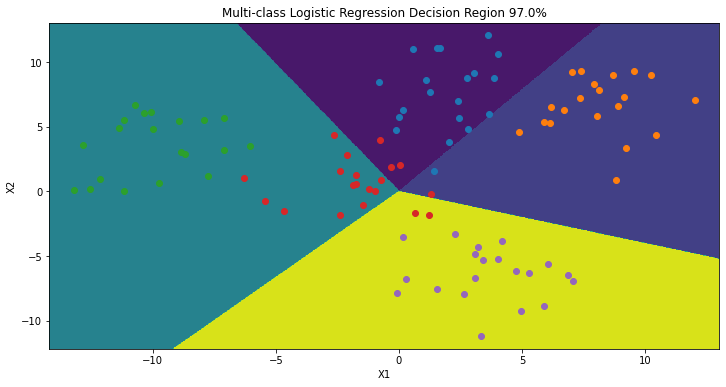

In [24]:
plot_DR(X, y, model, 'Multi-class Logistic Regression Decision Region {}'.format(acc), h=0.05)

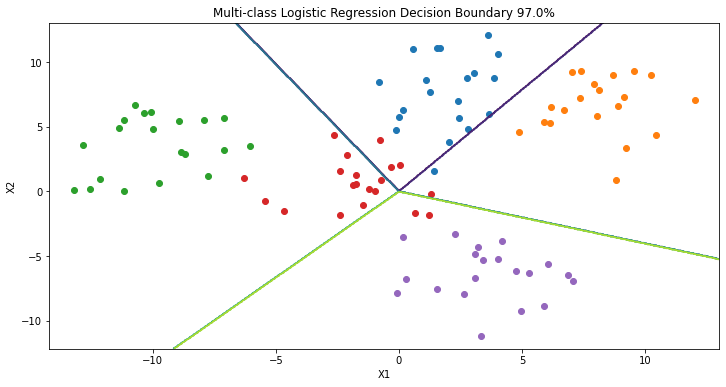

In [26]:
plot_DB(X, y, model, 'Multi-class Logistic Regression Decision Boundary {}'.format(acc), h=0.05)